# Modelos de Regresión Lineal

## Análisis Exploratorio de Datos 

### Carga del dataset

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_file_path = "data/train_set.csv"
df_train = pd.read_csv(train_file_path)

In [4]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
2,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
3,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
4,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


In [5]:
print(f"El dataset contiene {df_train.shape[0]} filas y {df_train.shape[1]} columnas.")

El dataset contiene 1168 filas y 80 columnas.


### Limpieza de datos

Manejo de Valores Nulos - Se  obtienen la cantidad de valores nulos y el porcentaje para determinar que datos se pueden eliminar y como manejar aquellos que representan una gran porcion de los datos

In [6]:
def relevant_null_value_percentage(df, umbral):
    na_not_missing = [
        "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
        "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
        "PoolQC", "Fence", "MiscFeature"
    ]
    df_cleaning = df.isnull().sum().reset_index()
    df_cleaning.columns = ["Columnas", "Valores Nulos"]
    df_cleaning["Porcentaje de Valores Nulos"] = (df_cleaning["Valores Nulos"] / len(df)) * 100
    df_cleaning["Tipo de Nulo"] = df_cleaning["Columnas"].apply(
        lambda x: "No Aplica" if x in na_not_missing else "Dato Faltante"
    )
    df_cleaning = df_cleaning[df_cleaning["Porcentaje de Valores Nulos"] > umbral]
    df_cleaning = df_cleaning.sort_values(by="Porcentaje de Valores Nulos", ascending=False)

    return df_cleaning

In [7]:
df_nulos = relevant_null_value_percentage(df_train, 0)
print(df_nulos)

        Columnas  Valores Nulos  Porcentaje de Valores Nulos   Tipo de Nulo
71        PoolQC           1162                    99.486301      No Aplica
73   MiscFeature           1122                    96.061644      No Aplica
5          Alley           1094                    93.664384      No Aplica
72         Fence            935                    80.051370      No Aplica
24    MasVnrType            683                    58.476027  Dato Faltante
56   FireplaceQu            547                    46.832192      No Aplica
2    LotFrontage            217                    18.578767  Dato Faltante
57    GarageType             64                     5.479452      No Aplica
58   GarageYrBlt             64                     5.479452  Dato Faltante
59  GarageFinish             64                     5.479452      No Aplica
62    GarageQual             64                     5.479452      No Aplica
63    GarageCond             64                     5.479452      No Aplica
30      Bsmt

Para los columnas que presenten un porcentaje a 5% se deben trabajar los datos y para aquellas con un porcentaje menor a 5% se pueden eliminar esas filas con los datos nulos.

In [8]:
df_train_cleaned = df_train.copy()
# 1. Manejo de valores en MasVnrType con la moda (valor más frecuente)
mode_masvnrtype = df_train_cleaned["MasVnrType"].mode()[0]  # Obtener la moda
df_train_cleaned.loc[:, "MasVnrType"] = df_train_cleaned["MasVnrType"].fillna(mode_masvnrtype)

# 2. Manejo de  valores en LotFrontage con la mediana por Neighborhood
df_train_cleaned.loc[:, "LotFrontage"] = df_train_cleaned.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# 3. Imputar valores en GarageYrBlt con YearBuilt
df_train_cleaned.loc[:, "GarageYrBlt"] = df_train_cleaned["GarageYrBlt"].fillna(df_train_cleaned["YearBuilt"])

missing_after_imputation = df_train_cleaned[["MasVnrType", "LotFrontage", "GarageYrBlt"]].isnull().sum()

In [9]:
print("Valores nulos después de la imputación:")
print(missing_after_imputation)

Valores nulos después de la imputación:
MasVnrType     0
LotFrontage    0
GarageYrBlt    0
dtype: int64


Eliminar filas con valores null (menores al 5%)

In [10]:
df_train_cleaned = df_train_cleaned.dropna()
missing_after_drop = df_train_cleaned.isnull().sum()

In [11]:
print("Valores nulos después de eliminar filas con datos faltantes:")
print(missing_after_drop)

Valores nulos después de eliminar filas con datos faltantes:
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64


Transformación de variables categóricas

In [12]:
# 1. Identificar variables categóricas
categorical_vars = df_train.select_dtypes(include=['object']).columns

# 2. Decidir el tipo de transformación
# Label Encoding para variables con orden lógico
label_enc_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                  'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

# One-Hot Encoding para el resto
one_hot_enc_vars = [col for col in categorical_vars if col not in label_enc_vars]

# 3. Aplicar Label Encoding
label_encoders = {}
for col in label_enc_vars:
    le = LabelEncoder()
    # Convertimos a string para evitar problemas con NaN
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    label_encoders[col] = le

# 4. Aplicar One-Hot Encoding
df_train_one_hot_encoded = pd.get_dummies(df_train[one_hot_enc_vars])

# 5. Unir los resultados al conjunto de datos original
df_train_transformed = pd.concat([df_train.drop(columns=one_hot_enc_vars), df_train_one_hot_encoded], axis=1)

# Resultados
{

    "Total de Columnas Después de Transformación": df_train_transformed.shape[1]
}


{'Total de Columnas Después de Transformación': 252}

Identificación de outliers y manejo de los mismos

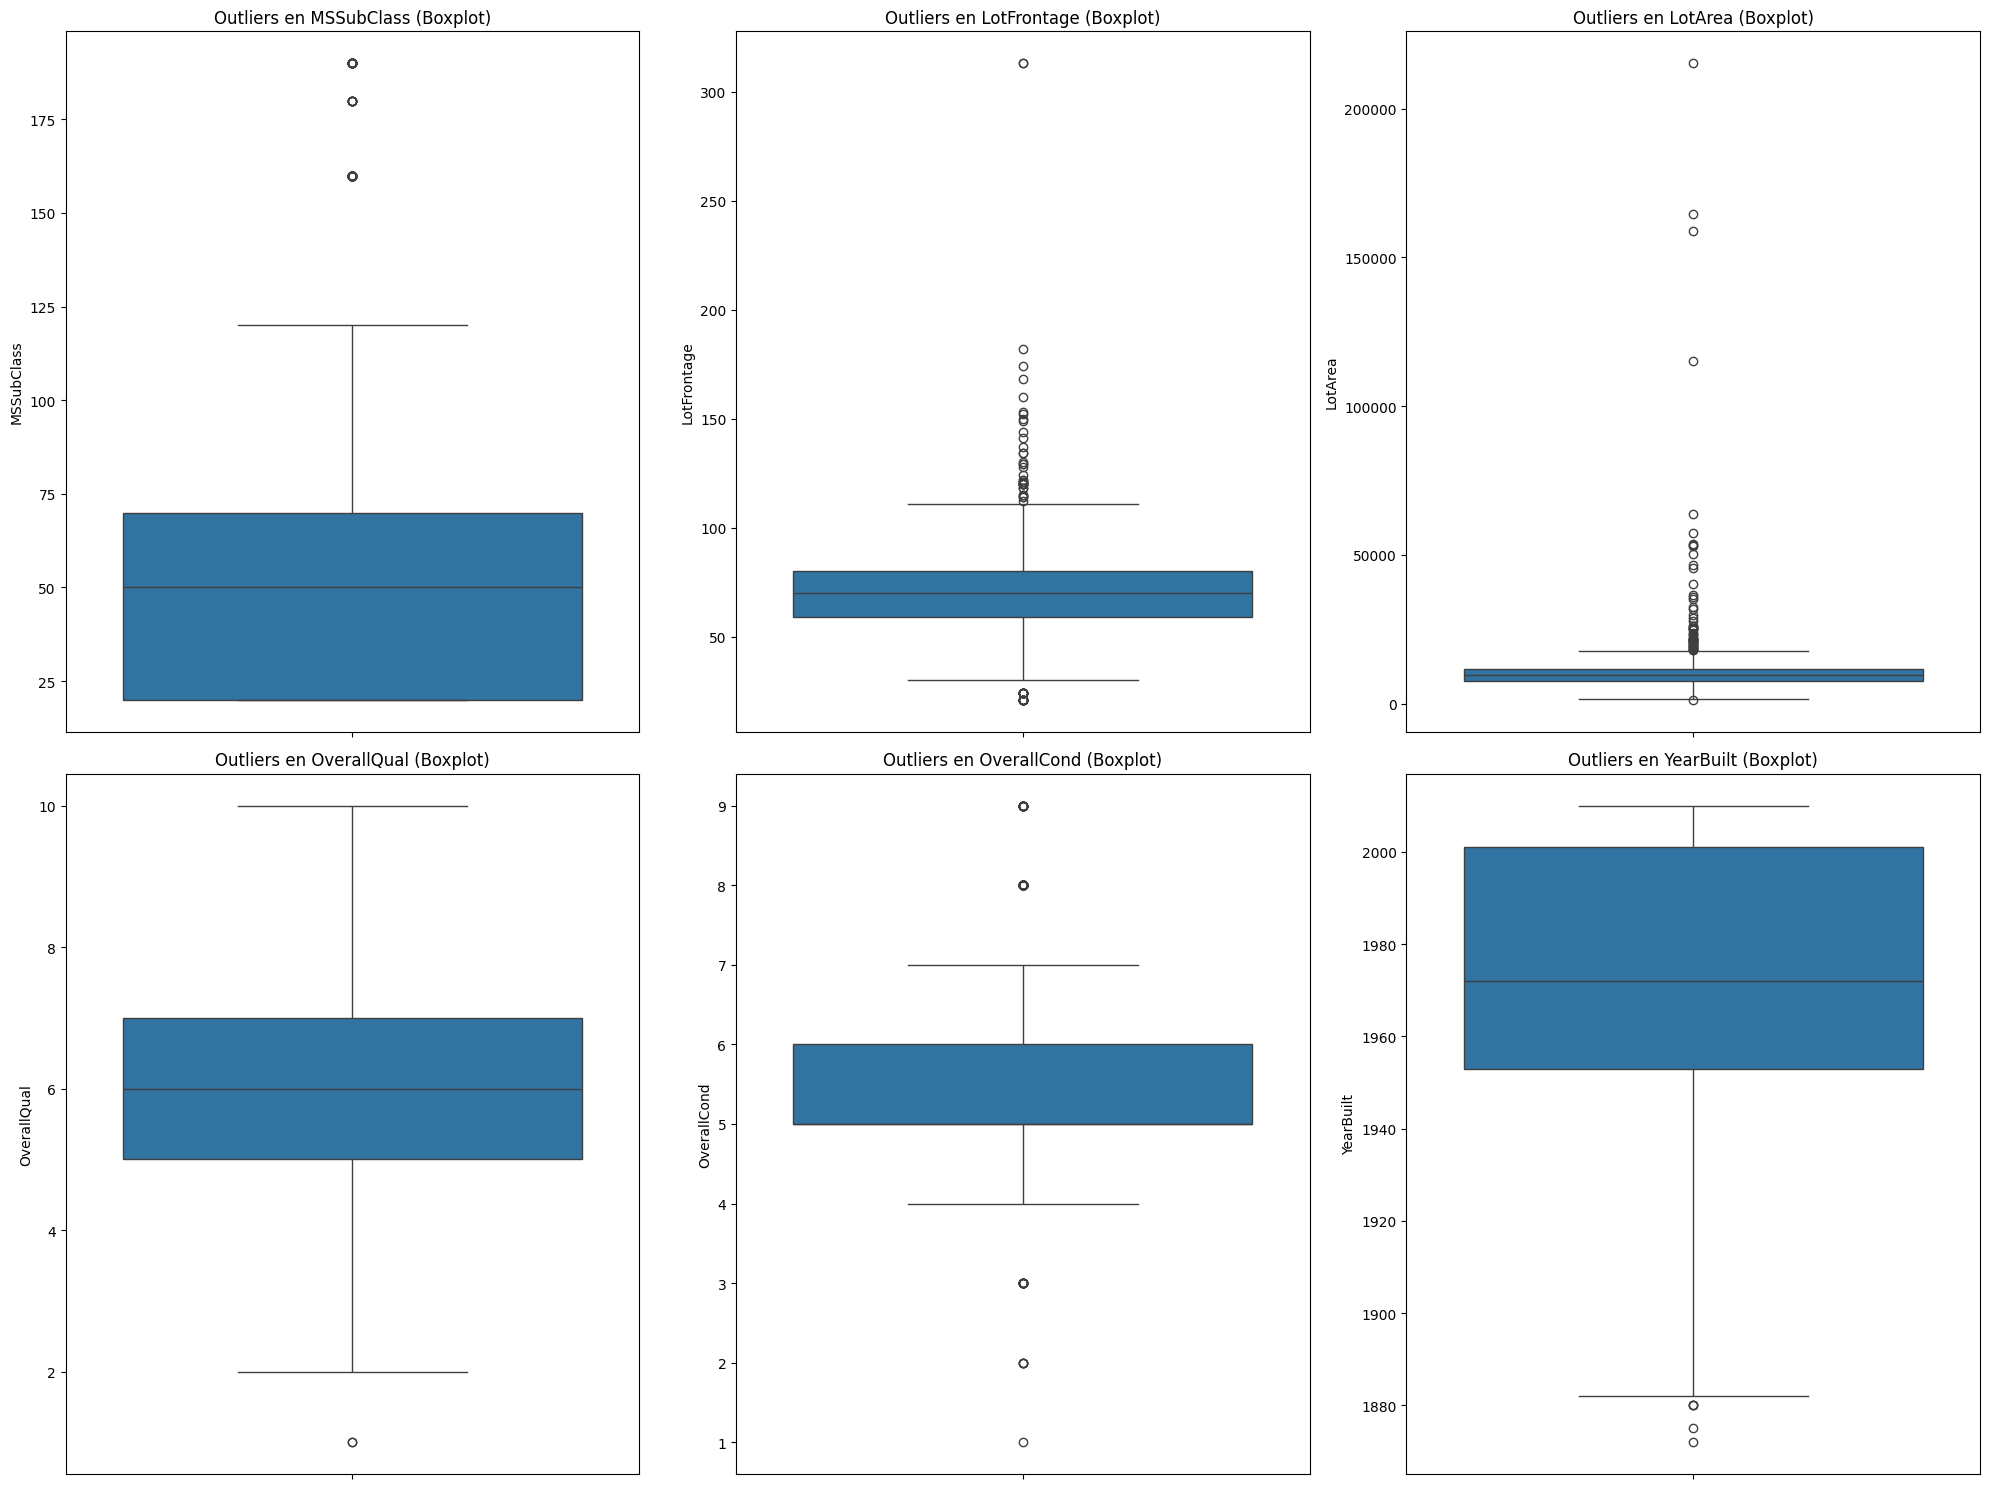

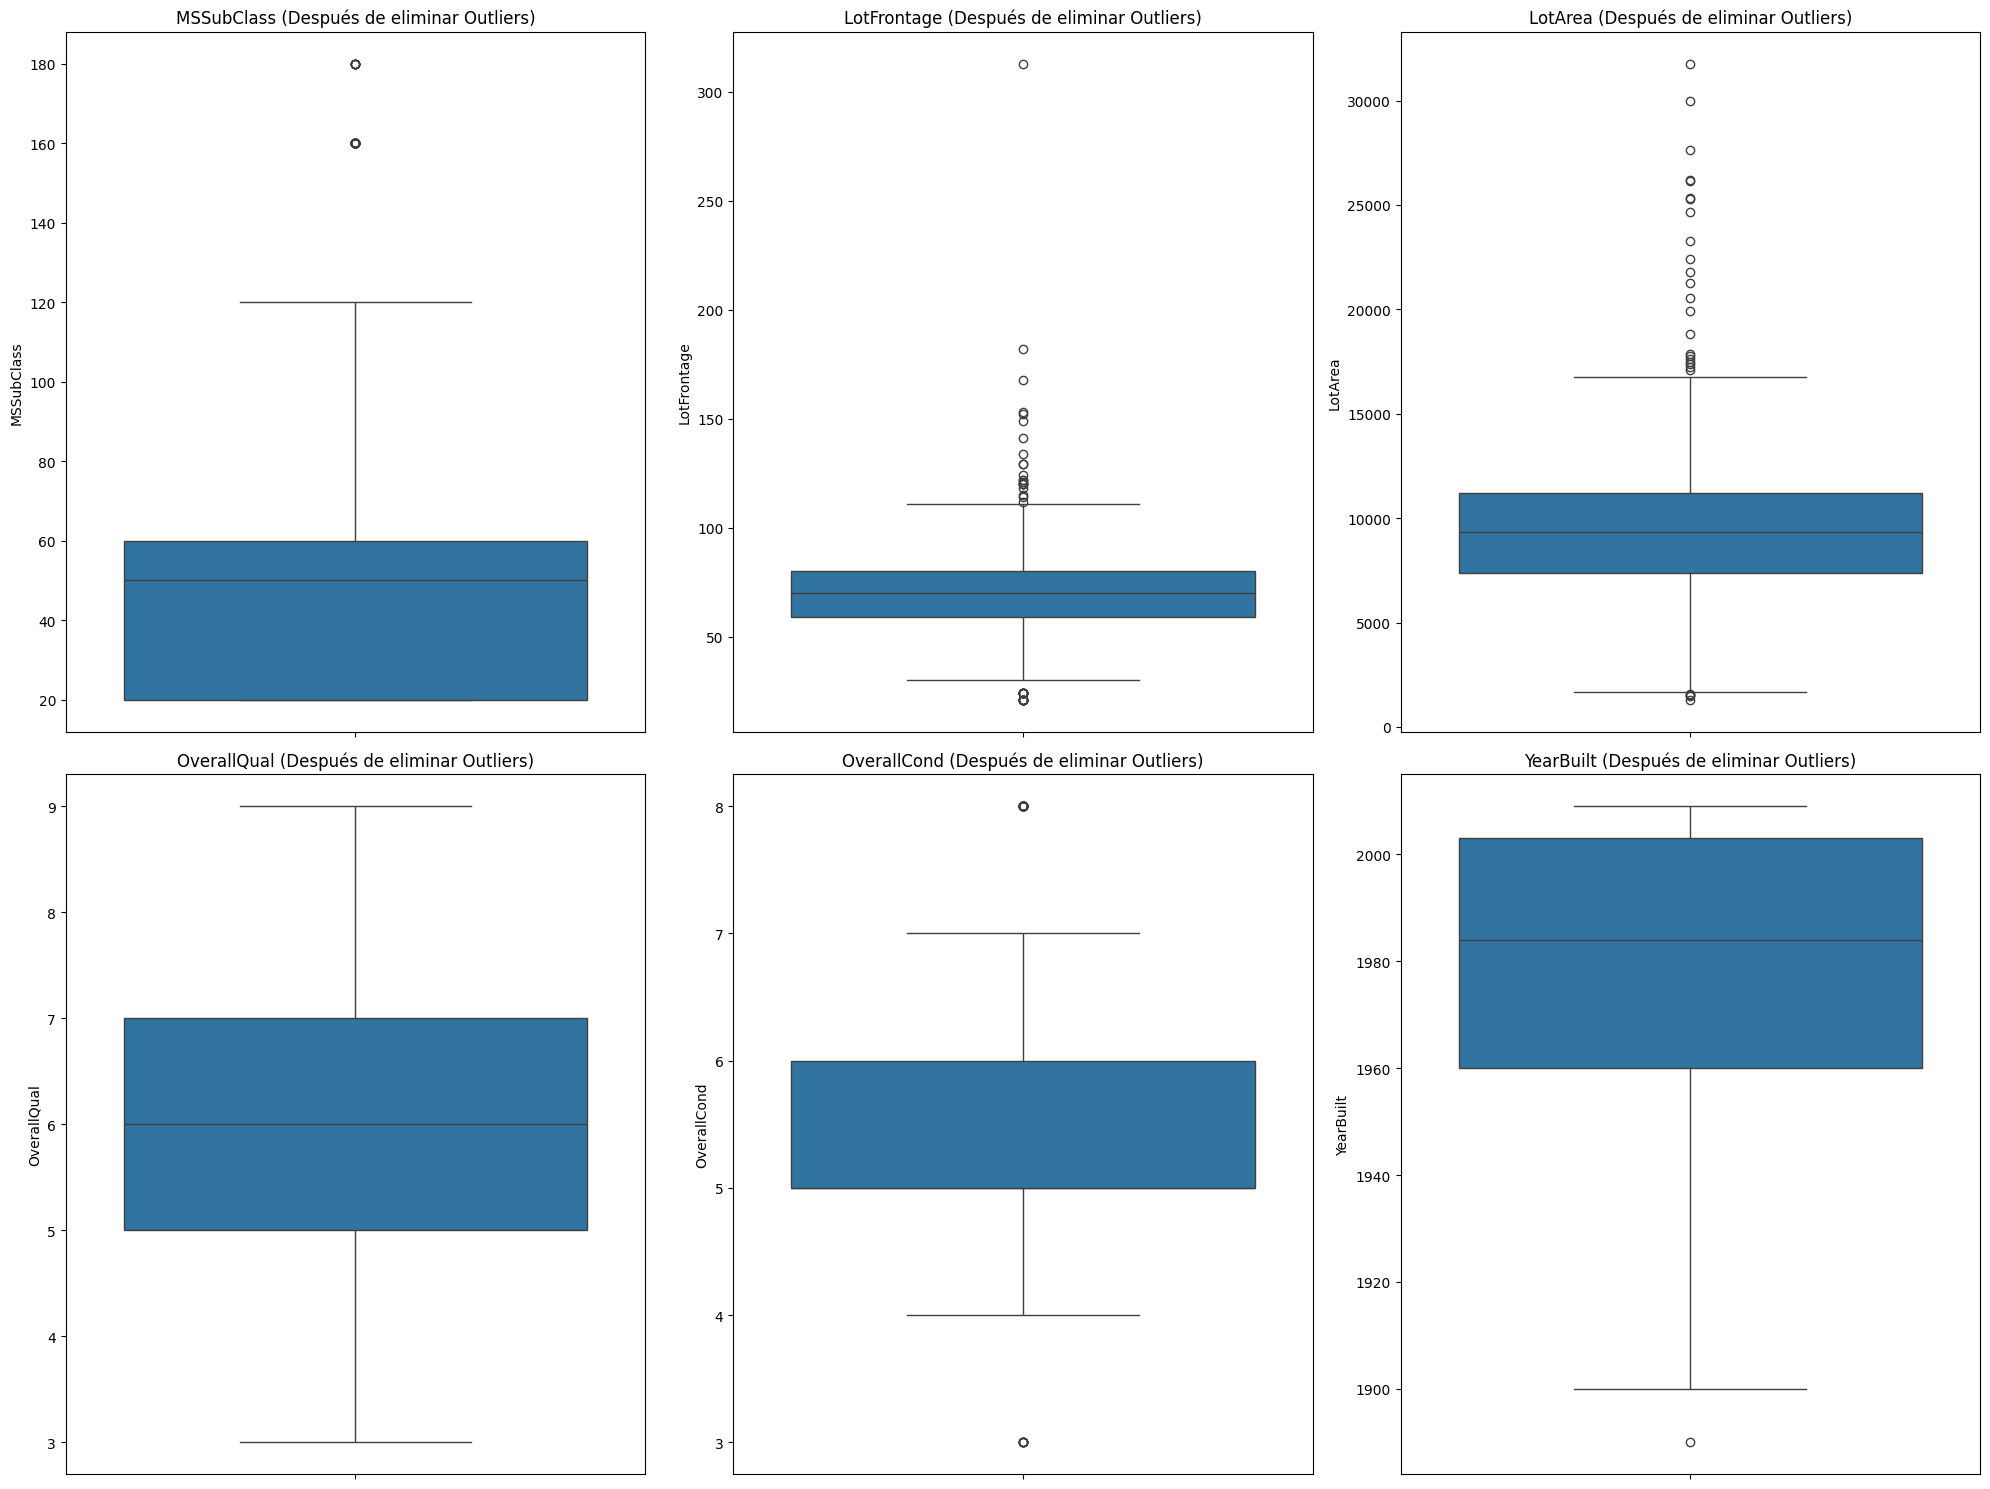

{'Total Outliers Identificados': 442,
 'Total Filas antes de limpiar': 1168,
 'Total Filas después de limpiar': 726}

In [13]:
from scipy.stats import zscore

# 1. Visualización de Outliers usando Boxplot
numerical_vars = df_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_train[col])
    plt.title(f'Outliers en {col} (Boxplot)')
plt.tight_layout()
plt.show()

# 2. Identificación de Outliers usando Z-score
outliers = {}
for col in numerical_vars:
    z_scores = zscore(df_train[col].dropna())
    outliers[col] = np.where(np.abs(z_scores) > 3)[0]  # Z-score > 3 se considera outlier

# 3. Manejo de Outliers: Remover outliers extremos (Z-score > 3)
# Concatenar todos los índices de outliers
all_outliers = np.concatenate(list(outliers.values()))
unique_outliers = np.unique(all_outliers)  # Evitar duplicados

# Remover outliers manteniendo los índices originales
df_train_cleaned = df_train.drop(index=unique_outliers)

# 4. Visualización después del manejo de outliers
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_train_cleaned[col])
    plt.title(f'{col} (Después de eliminar Outliers)')
plt.tight_layout()
plt.show()

# Resultados
{
    "Total Outliers Identificados": len(unique_outliers),
    "Total Filas antes de limpiar": len(df_train),
    "Total Filas después de limpiar": len(df_train_cleaned)
}


Estandarizació o normalización de variables en base a demnadas.

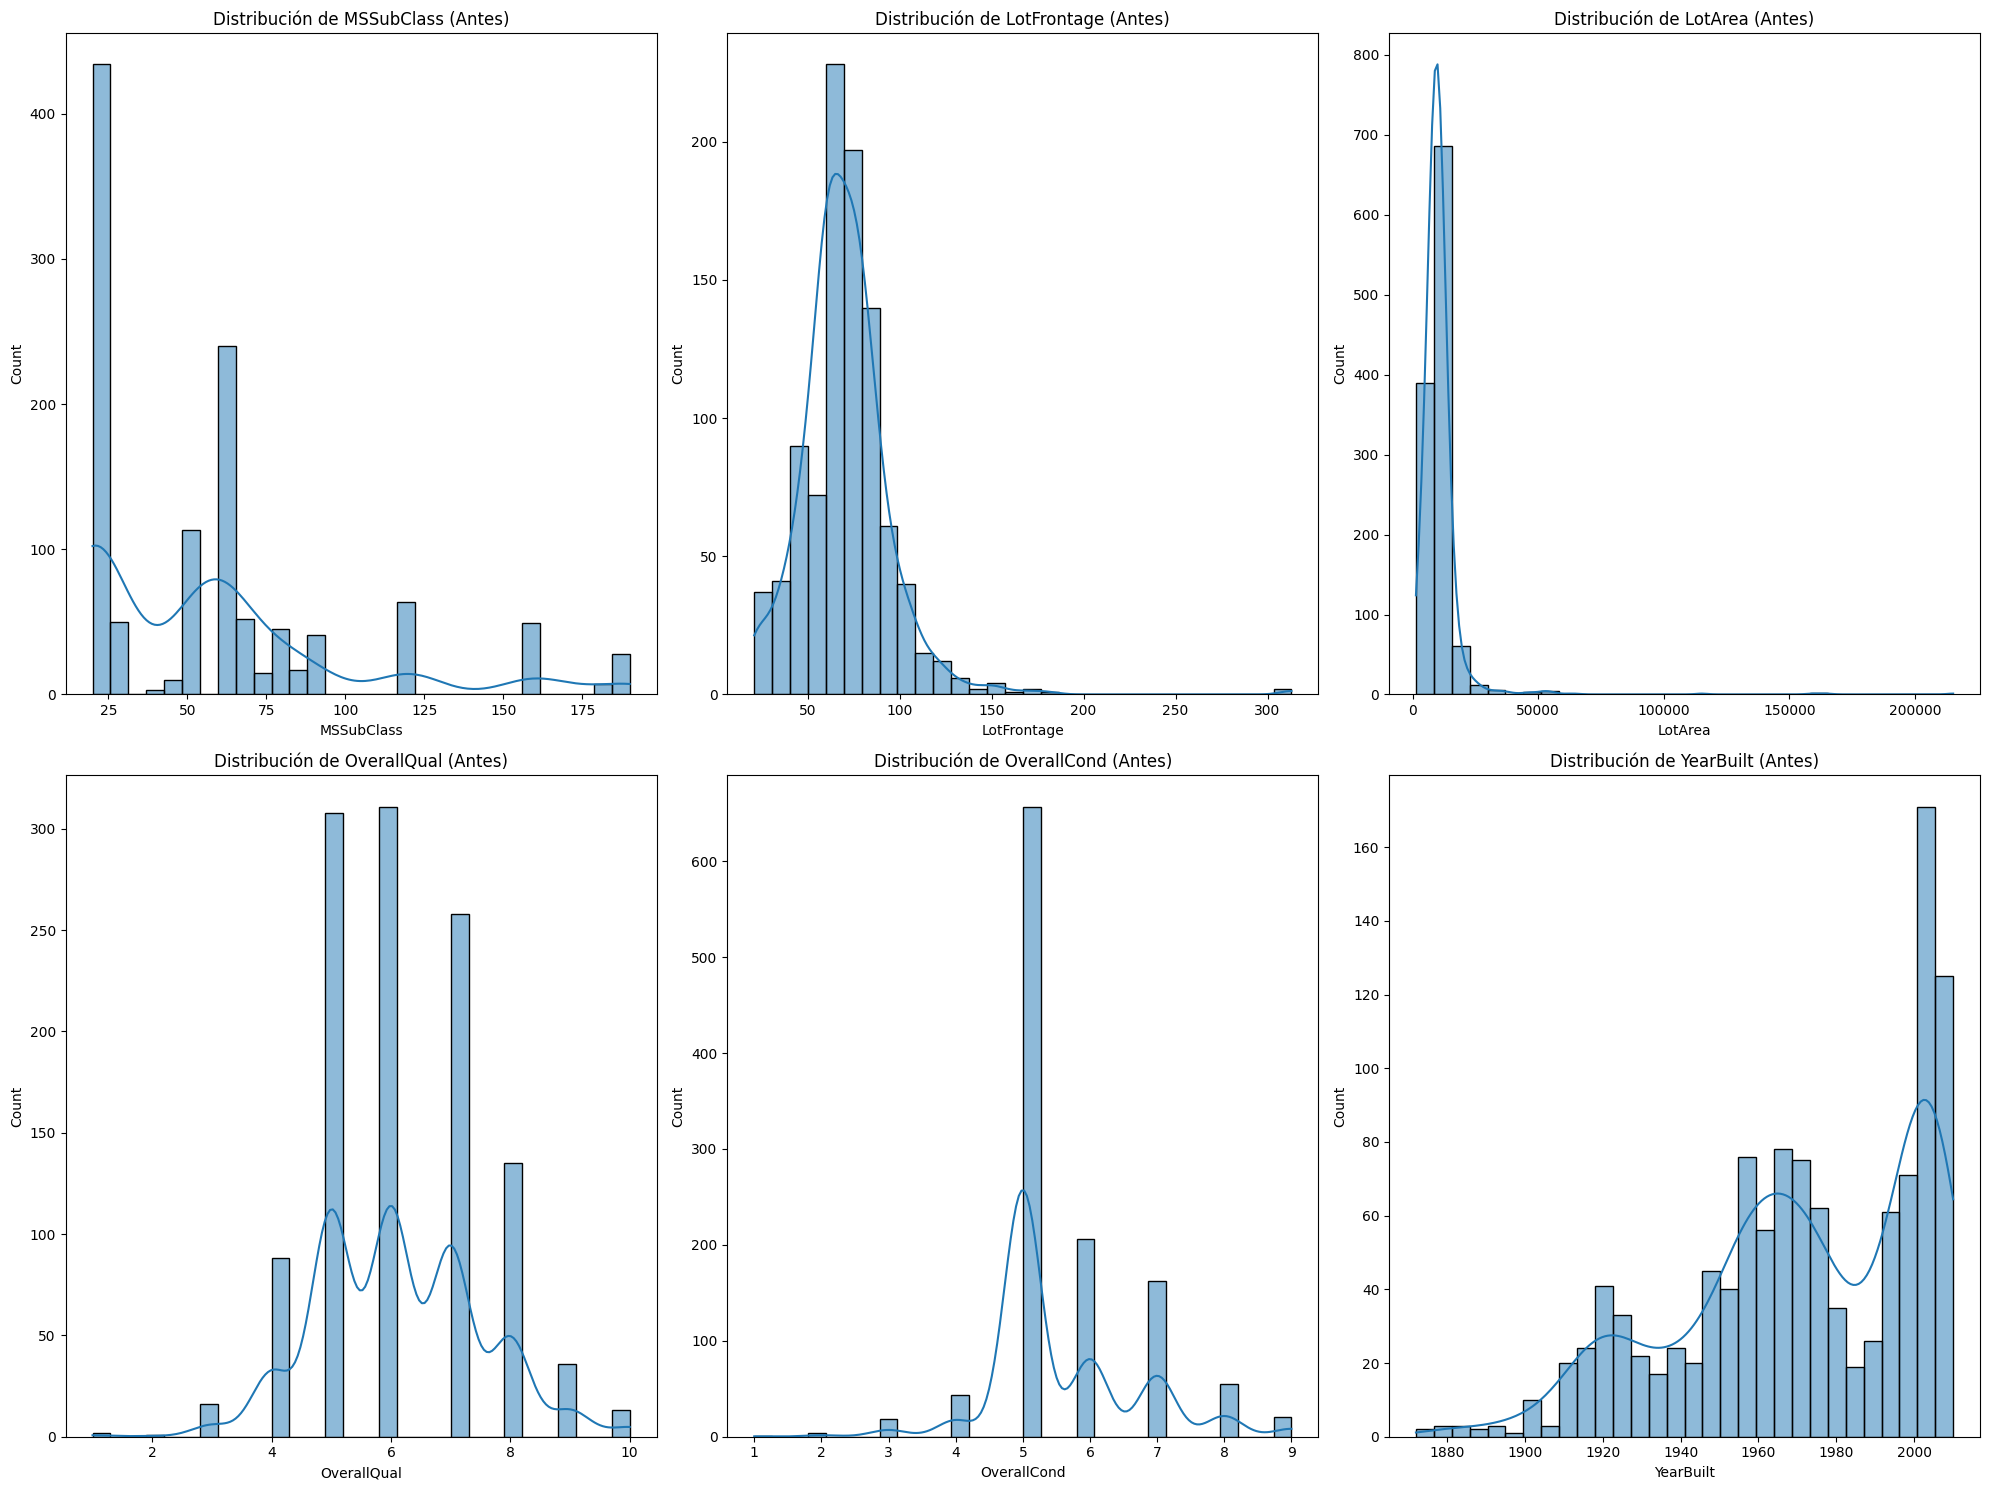

In [14]:
# 1. Análisis de Distribución de Variables Numéricas
numerical_vars = df_train_transformed.select_dtypes(include=['int64', 'float64']).columns

# Visualización de distribuciones antes de la transformación
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_transformed[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribución de {col} (Antes)')
plt.tight_layout()
plt.show()

# 2. Estandarización y Normalización en base a la distribución
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()



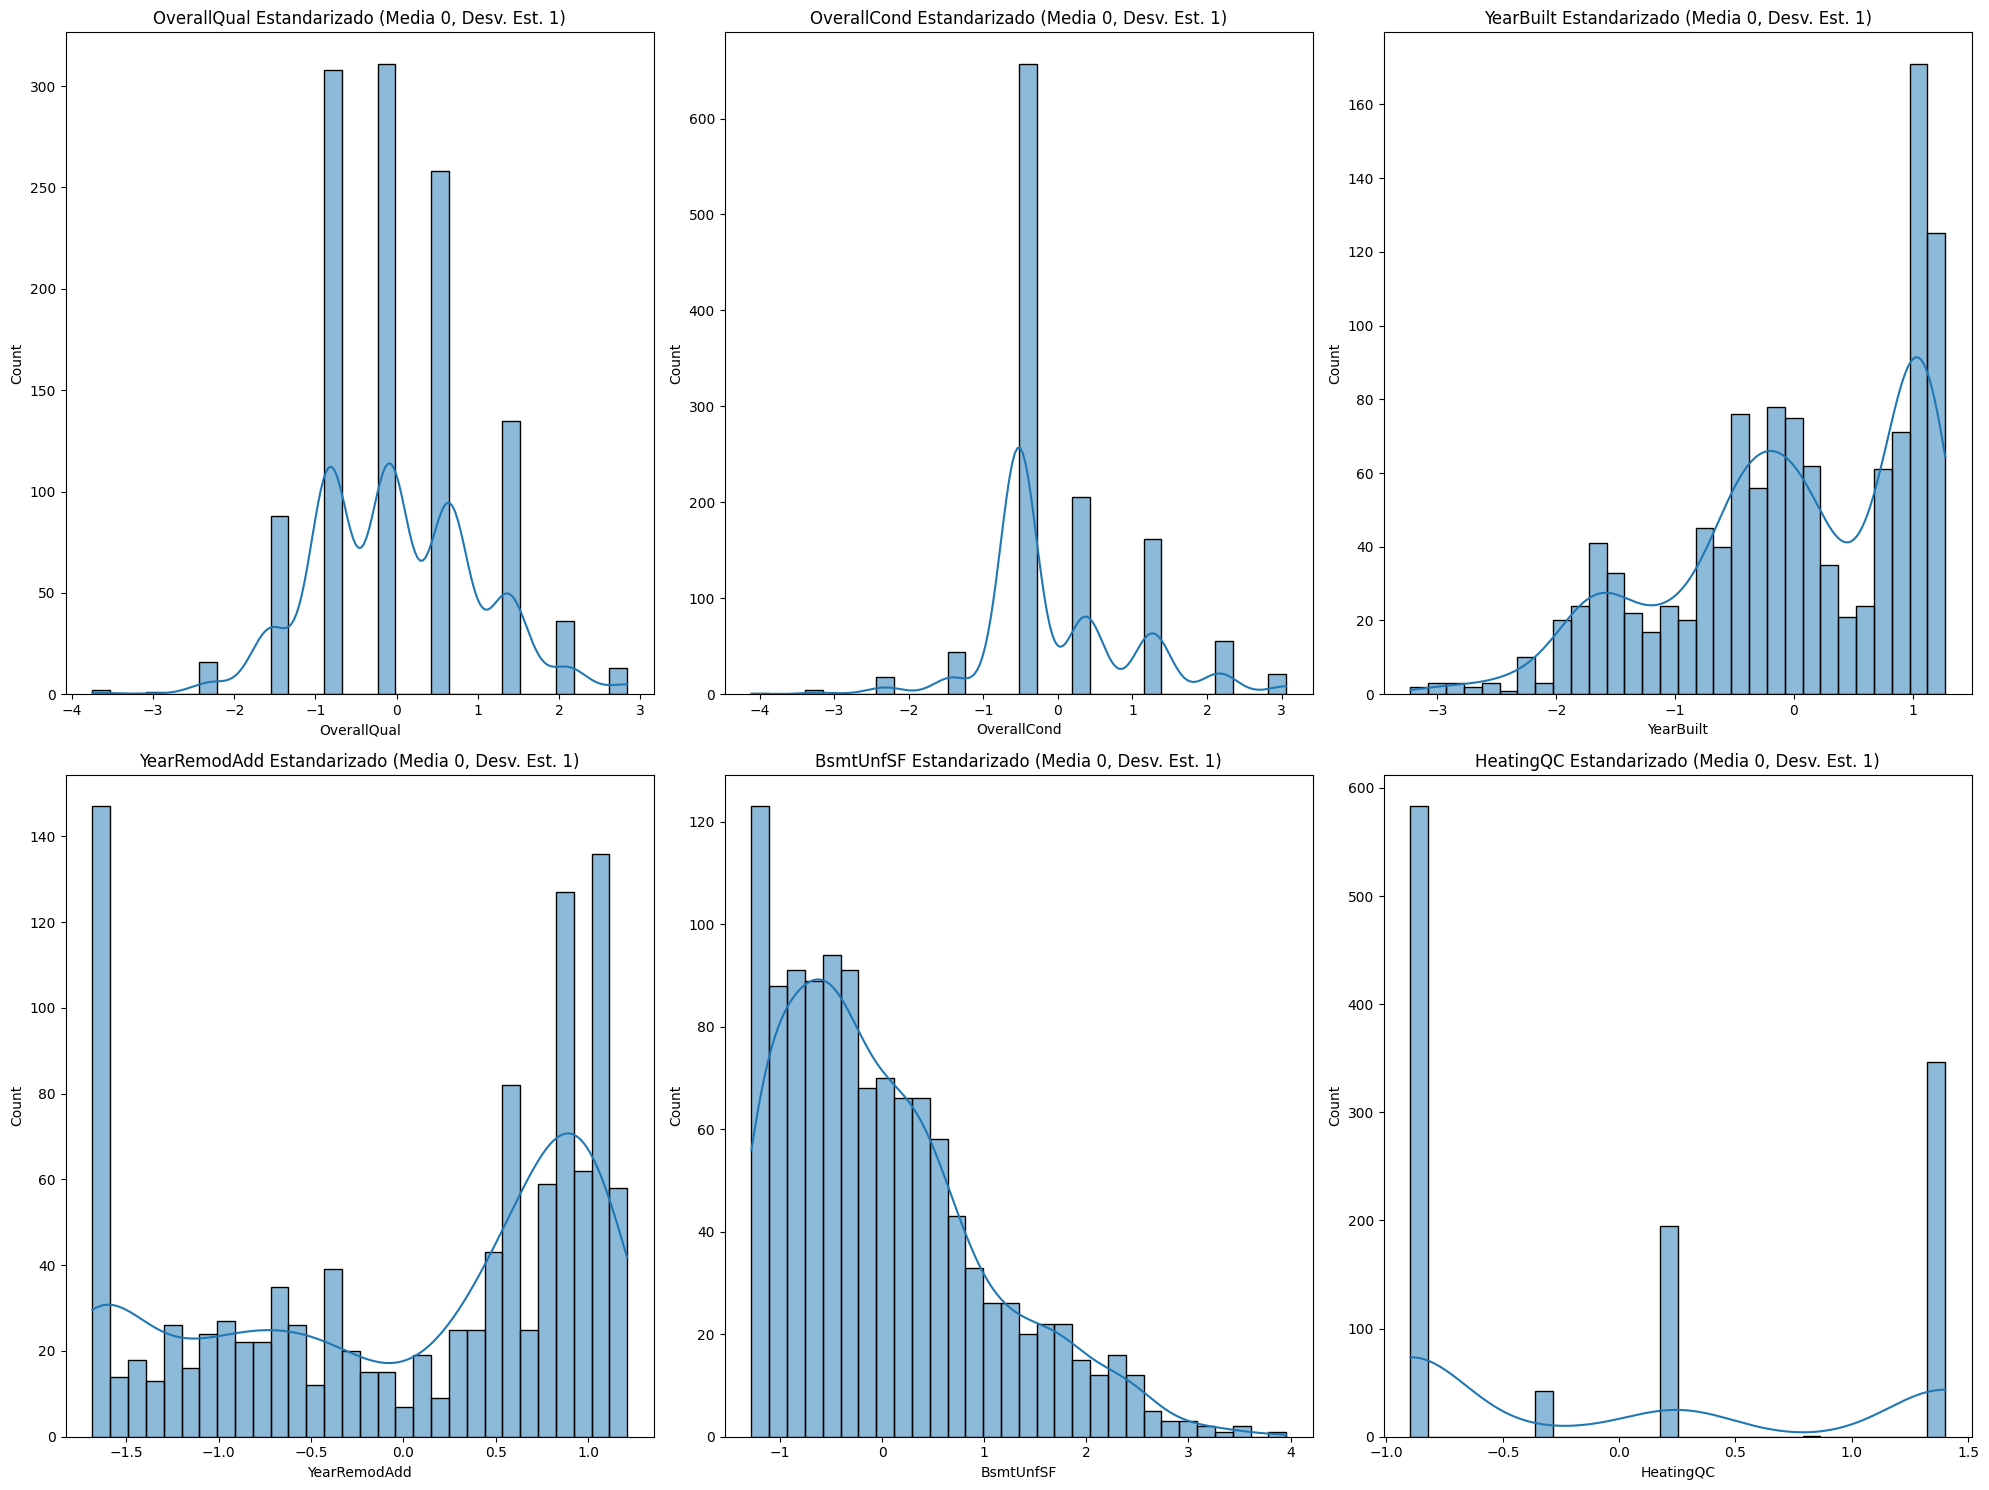

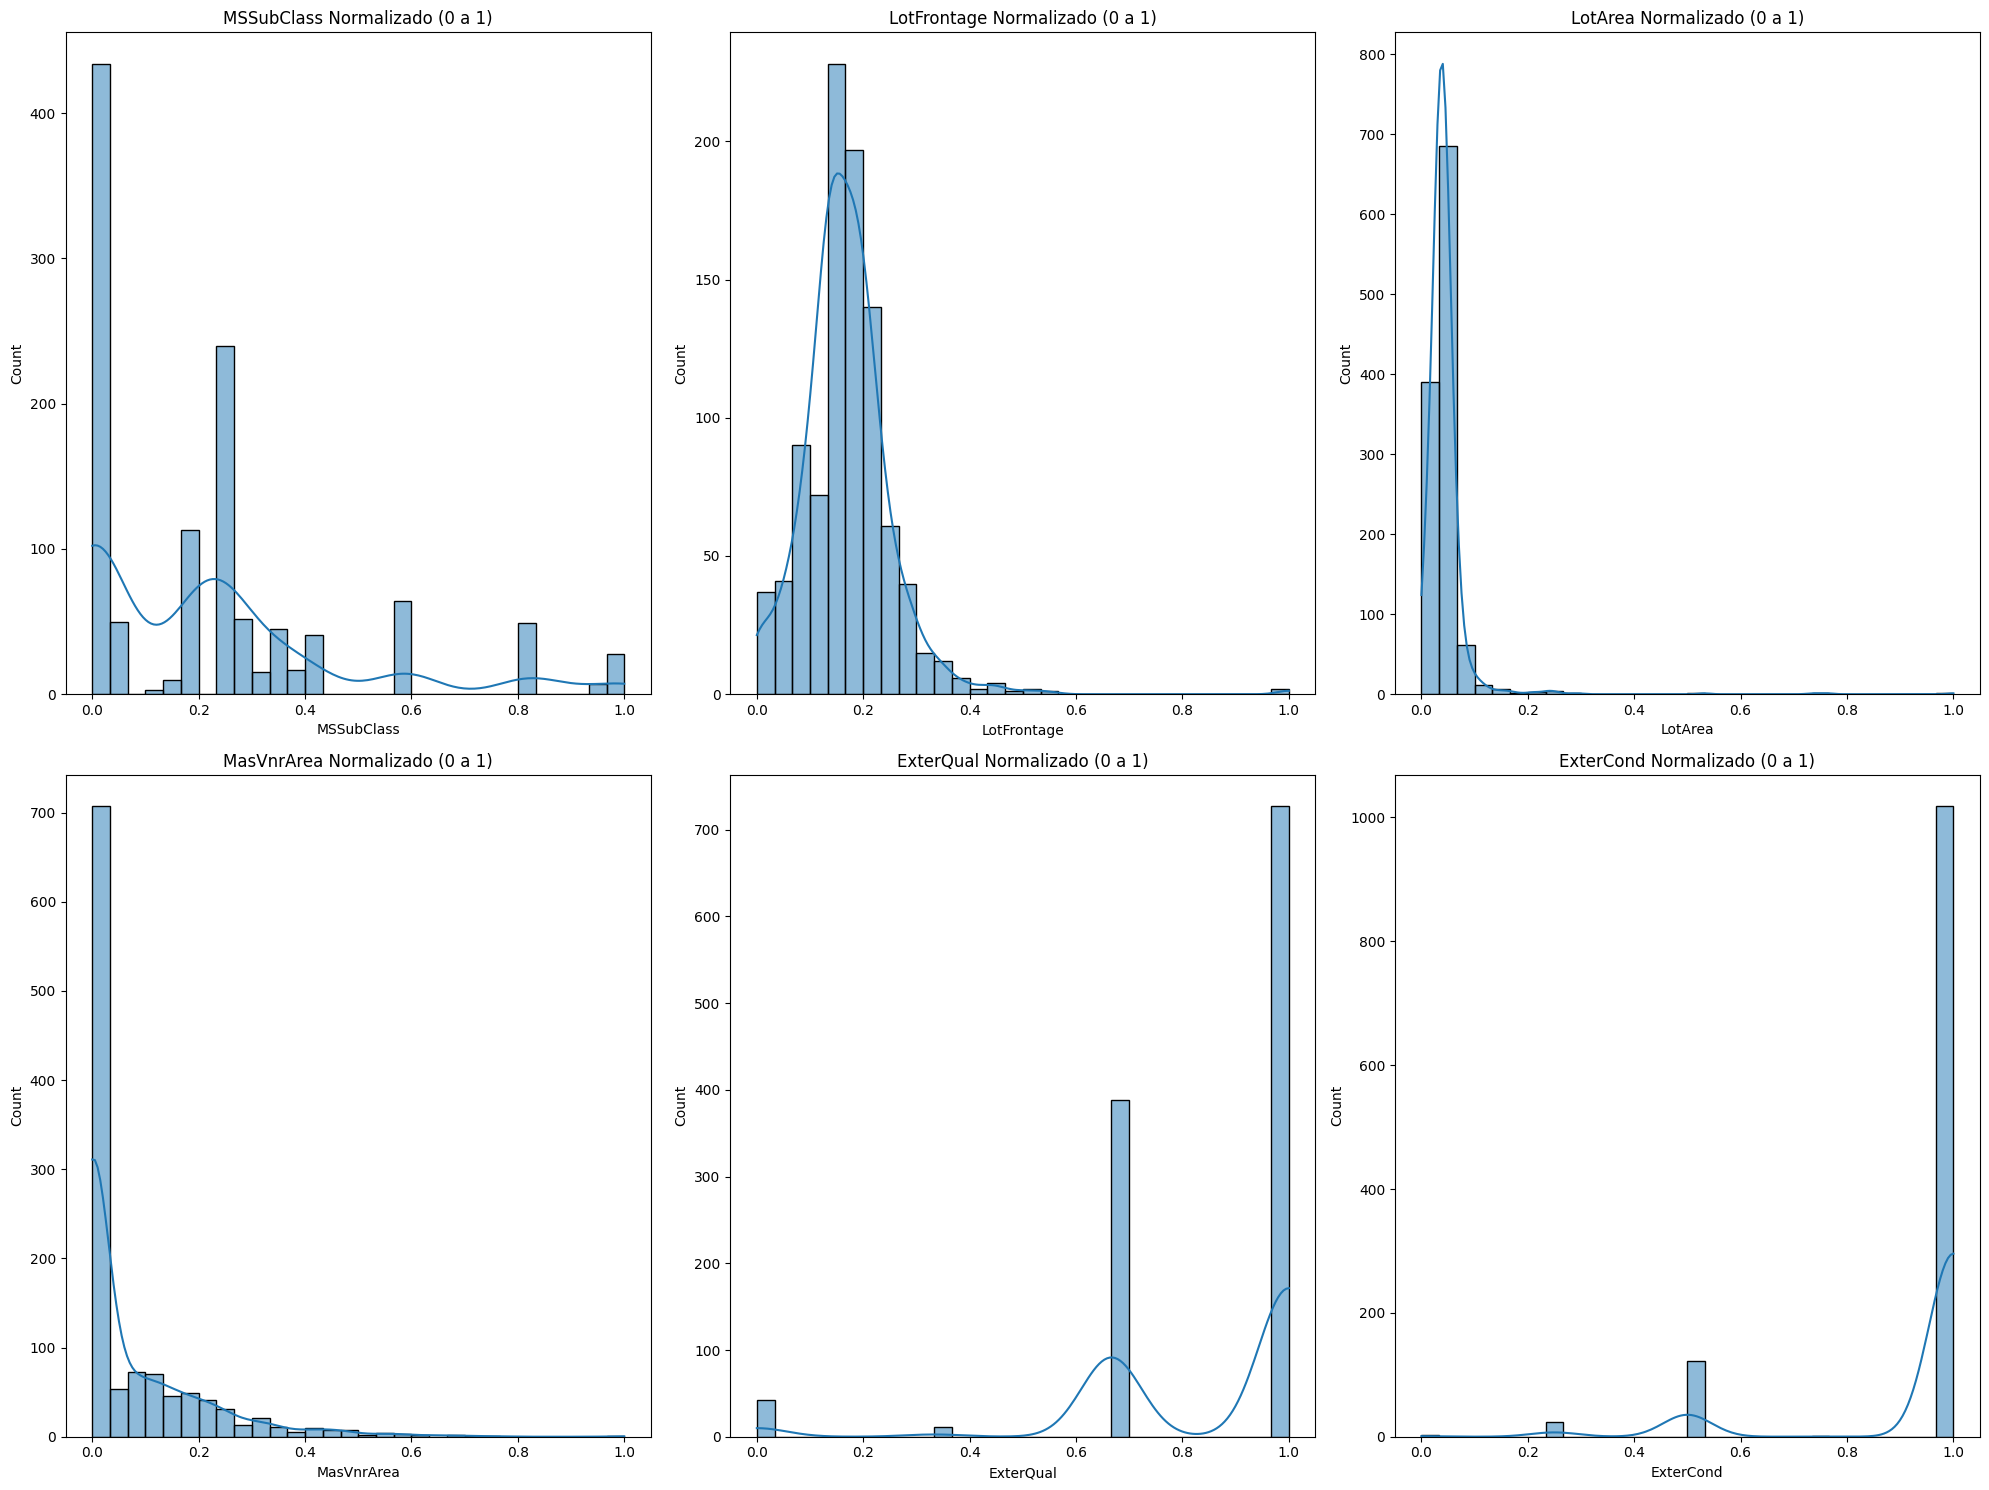

{'Resumen Estandarización':         OverallQual   OverallCond     YearBuilt  YearRemodAdd     BsmtUnfSF  \
 count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
 mean  -5.170902e-17 -2.281280e-16 -1.417435e-15  4.653812e-15  5.322987e-17   
 std    1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00   
 min   -3.746488e+00 -4.109739e+00 -3.227597e+00 -1.683818e+00 -1.278864e+00   
 25%   -8.204446e-01 -5.241741e-01 -5.859221e-01 -9.118065e-01 -7.801788e-01   
 50%   -8.893368e-02 -5.241741e-01  3.373017e-02  4.392138e-01 -2.030489e-01   
 75%    6.425772e-01  3.722173e-01  9.795152e-01  9.217210e-01  5.371341e-01   
 max    2.837110e+00  3.061391e+00  1.273035e+00  1.211225e+00  3.956768e+00   
 
           HeatingQC      2ndFlrSF  BsmtFullBath      FullBath      HalfBath  \
 count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
 mean   1.825024e-17  4.562560e-18 -7.832395e-17 -5.475072e-17 -1.140640e-16   
 std    1.0

In [15]:
# Identificamos variables con distribución normal y sesgada
# Usando el criterio de sesgo: Si el skew es > 1 o < -1, se considera sesgada

dist_normal = []
dist_sesgada = []

for col in numerical_vars:
    skewness = skew(df_train_transformed[col].dropna())
    if abs(skewness) > 1:
        dist_sesgada.append(col)
    else:
        dist_normal.append(col)

# Aplicar estandarización a variables con distribución normal
df_train_standardized = df_train_transformed.copy()
df_train_standardized[dist_normal] = standard_scaler.fit_transform(df_train_transformed[dist_normal])

# Aplicar normalización a variables con distribución sesgada
df_train_one_hot_encoded = df_train_transformed.copy()
df_train_one_hot_encoded[dist_sesgada] = min_max_scaler.fit_transform(df_train_transformed[dist_sesgada])

# 3. Verificación de Resultados
# Comprobar la media y desviación estándar en estandarización
standard_summary = df_train_standardized[dist_normal].describe()

# Comprobar los límites de 0 a 1 en normalización
normalized_summary = df_train_one_hot_encoded[dist_sesgada].describe()

# 4. Visualización después de la transformación
# Estandarización (Distribución Normal)
plt.figure(figsize=(20, 15))
for i, col in enumerate(dist_normal[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_standardized[col], bins=30, kde=True)
    plt.title(f'{col} Estandarizado (Media 0, Desv. Est. 1)')
plt.tight_layout()
plt.show()

# Normalización (Distribución Sesgada)
plt.figure(figsize=(20, 15))
for i, col in enumerate(dist_sesgada[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_one_hot_encoded[col], bins=30, kde=True)
    plt.title(f'{col} Normalizado (0 a 1)')
plt.tight_layout()
plt.show()

# Resultados
{
    "Resumen Estandarización": standard_summary,
    "Resumen Normalización": normalized_summary
}


### Análisis descriptivo

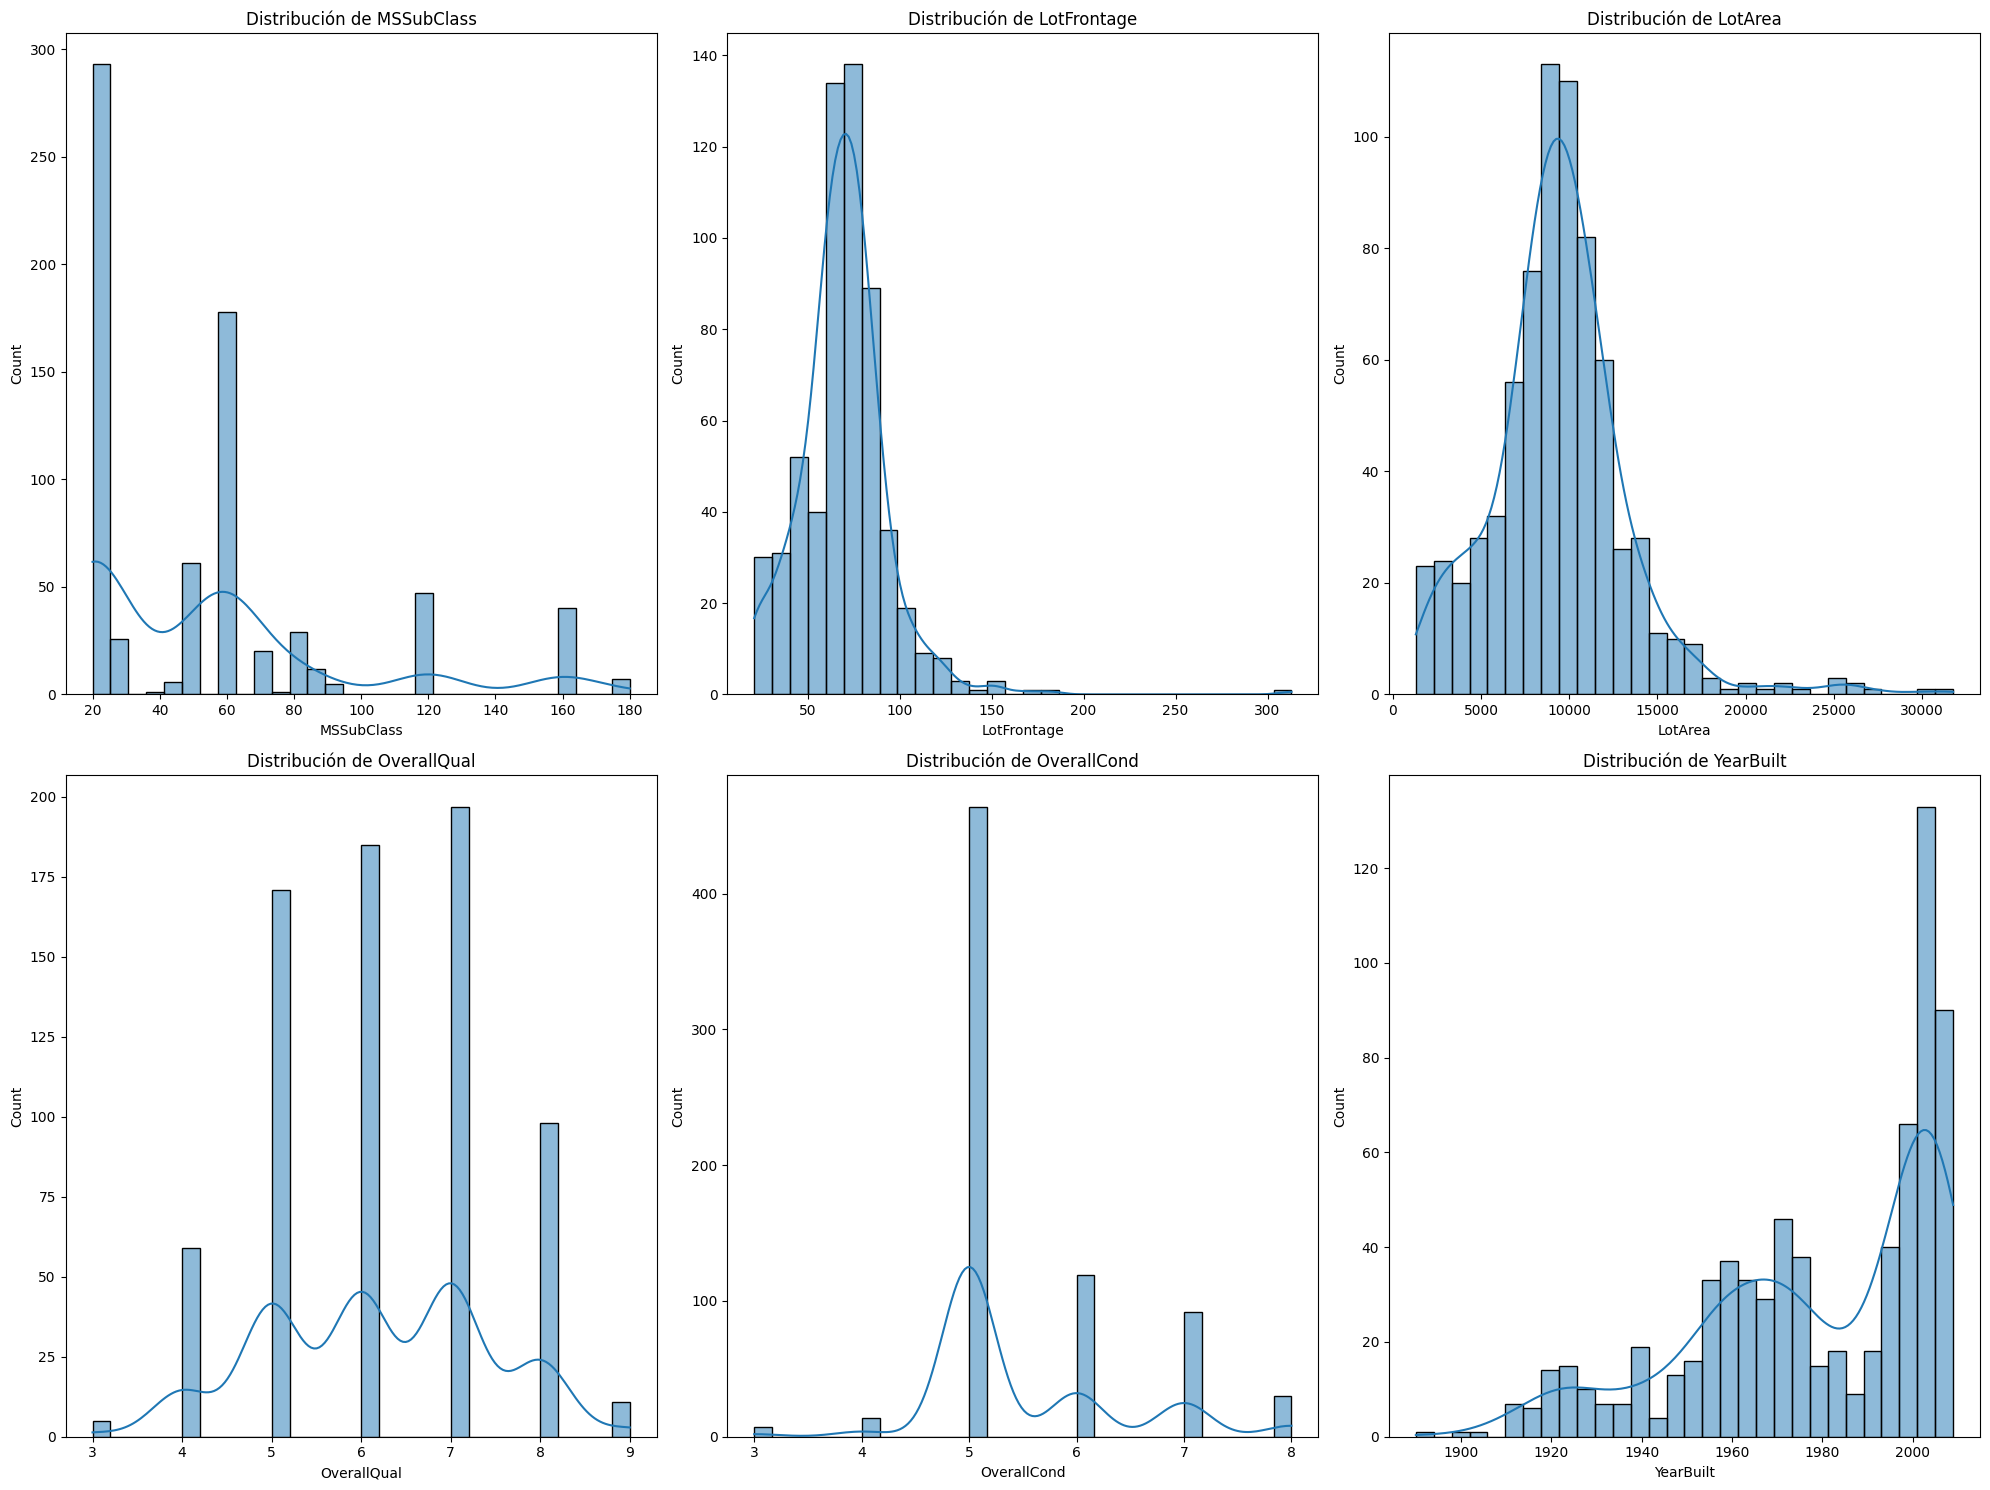

,Media,Mediana,Moda,Desviación Estándar,Varianza,Rango,Percentil 25,Percentil 50 (Mediana),Percentil 75
MSSubClass,54.056474,50.0,20.0,40.175970,1.614109e+03,160.0,20.0,50.0,60.00
LotFrontage,69.511745,70.0,60.0,24.466163,5.985931e+02,292.0,59.0,70.0,80.00
LotArea,9430.174931,9327.0,9600.0,3893.626117,1.516032e+07,30470.0,7388.5,9327.0,11213.00
OverallQual,6.168044,6.0,7.0,1.242633,1.544136e+00,6.0,5.0,6.0,7.00
OverallCond,5.502755,5.0,5.0,0.921389,8.489579e-01,5.0,5.0,5.0,6.00
YearBuilt,1978.606061,1984.0,2005.0,27.015534,7.298391e+02,119.0,1960.0,1984.0,2003.00
YearRemodAdd,1987.316804,1997.0,1950.0,20.056580,4.022664e+02,60.0,1970.0,1997.0,2004.75
MasVnrArea,92.697222,0.0,0.0,150.546395,2.266422e+04,975.0,0.0,0.0,151.50
ExterQual,2.570248,3.0,3.0,0.503666,2.536791e-01,2.0,2.0,3.0,3.00
ExterCond,3.826446,4.0,4.0,0.563404,3.174238e-01,2.0,4.0,4.0,4.00


In [16]:
# Identificación de variables numéricas
numerical_vars = df_train_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Cálculo de medidas estadísticas
medidas = pd.DataFrame(index=numerical_vars)

# Media
medidas['Media'] = df_train_cleaned[numerical_vars].mean()

# Mediana
medidas['Mediana'] = df_train_cleaned[numerical_vars].median()

# Moda (puede haber más de una, así que tomamos la primera)
medidas['Moda'] = df_train_cleaned[numerical_vars].mode().iloc[0]

# Desviación Estándar
medidas['Desviación Estándar'] = df_train_cleaned[numerical_vars].std()

# Varianza
medidas['Varianza'] = df_train_cleaned[numerical_vars].var()

# Rango
medidas['Rango'] = df_train_cleaned[numerical_vars].max() - df_train_cleaned[numerical_vars].min()

# Percentiles
medidas['Percentil 25'] = df_train_cleaned[numerical_vars].quantile(0.25)
medidas['Percentil 50 (Mediana)'] = df_train_cleaned[numerical_vars].quantile(0.50)
medidas['Percentil 75'] = df_train_cleaned[numerical_vars].quantile(0.75)

# Visualización de distribuciones
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_cleaned[col], bins=30, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# Mostrar resumen de medidas estadísticas
medidas.head(10)


### Visualización de datos
Se hace la visualización de los datos para mayor análisis. Asimismo, se determina las variables que puedan ser útiles para predecir los precios.

### Matriz de correlación 

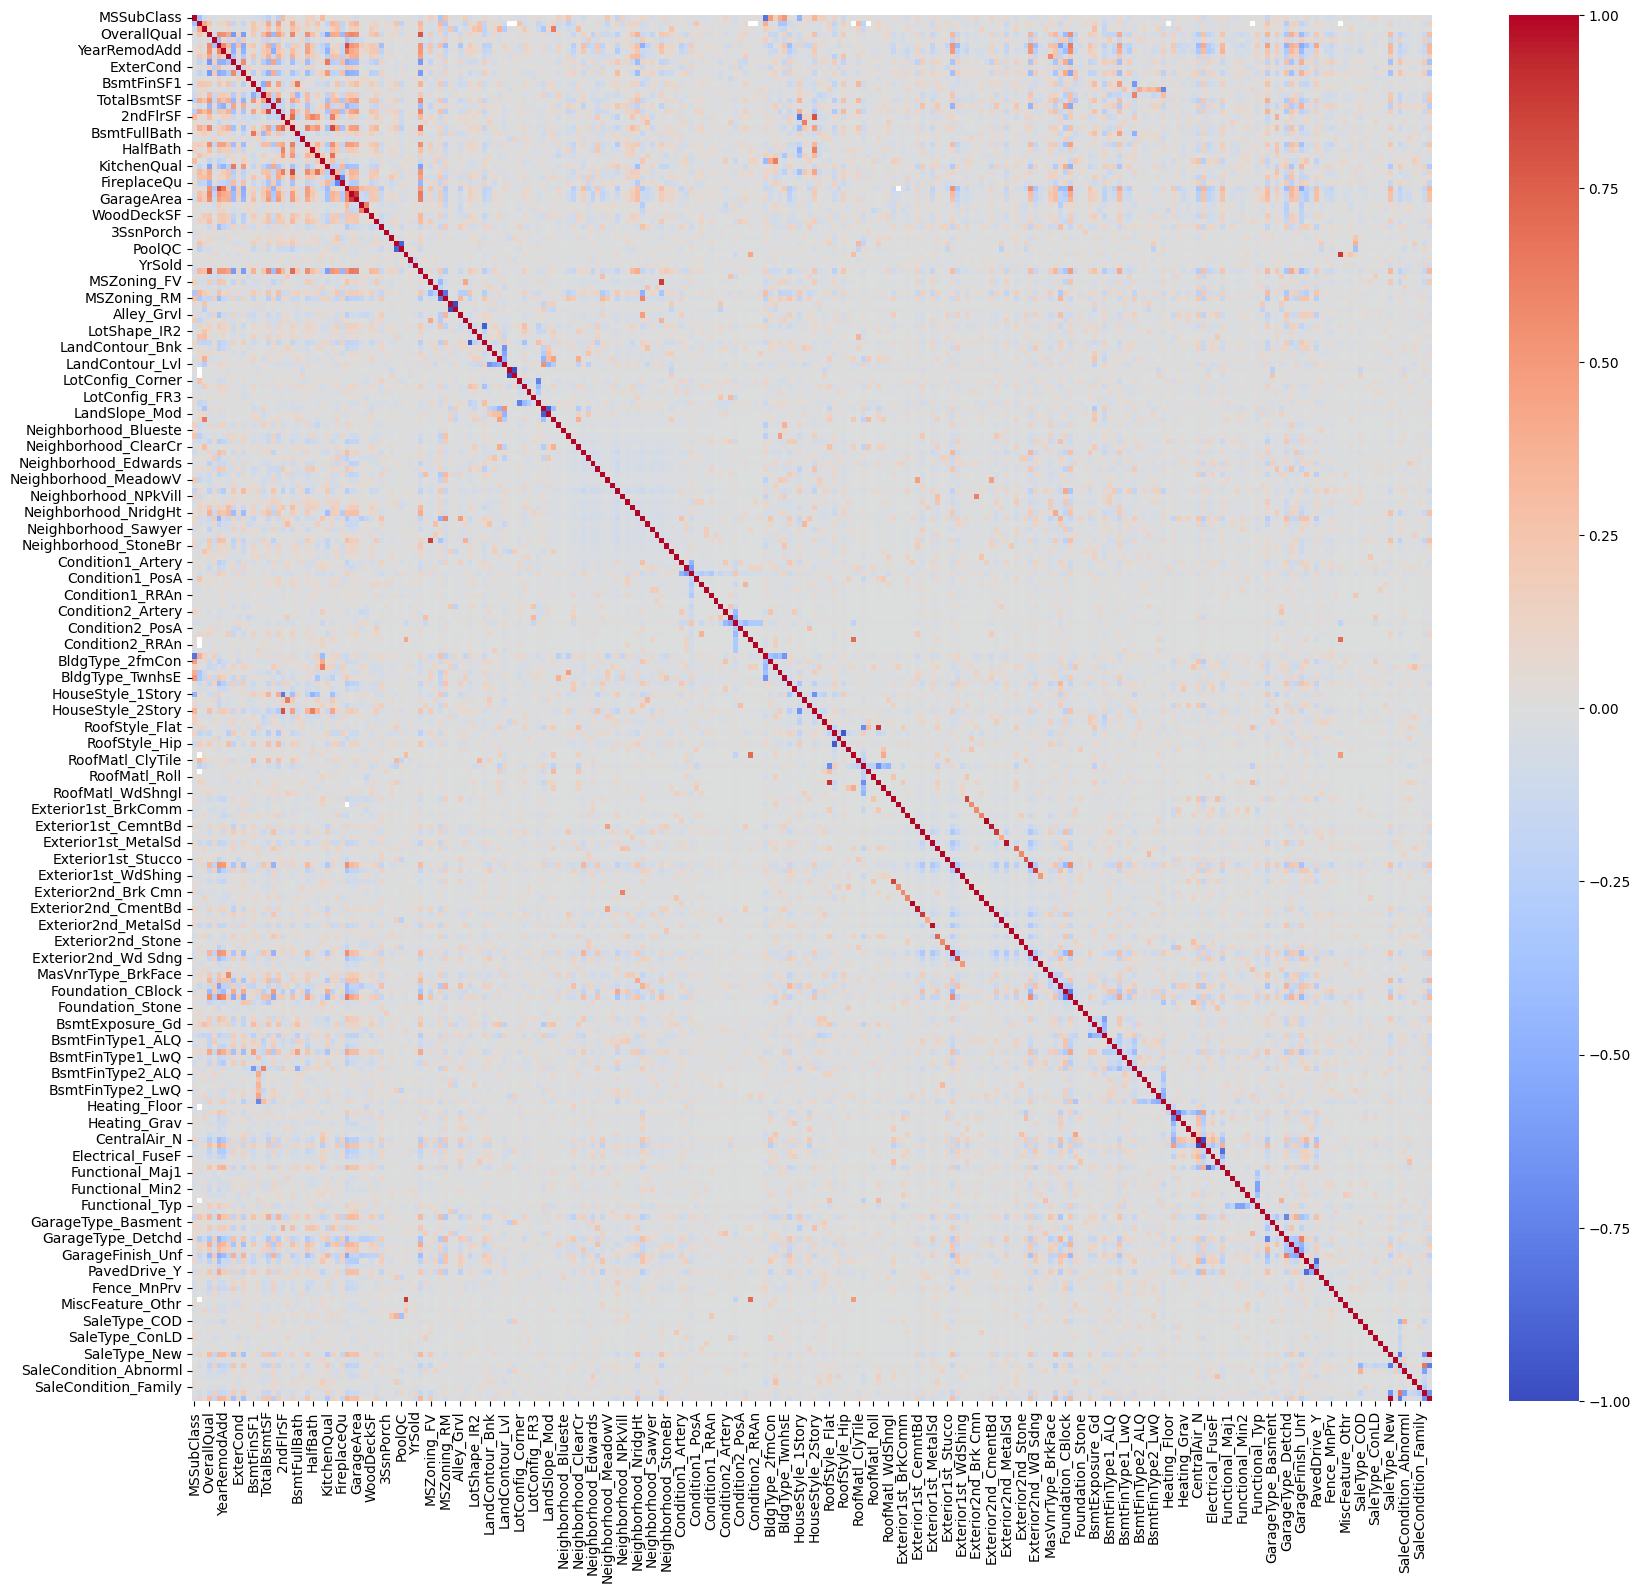

In [17]:
# matriz de correlación con todas las variables estandarizadas. Poco legible y no nos dice mucho.
correlation_matrix = df_train_standardized.corr()
plt.figure(figsize=(20, 18)) 
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

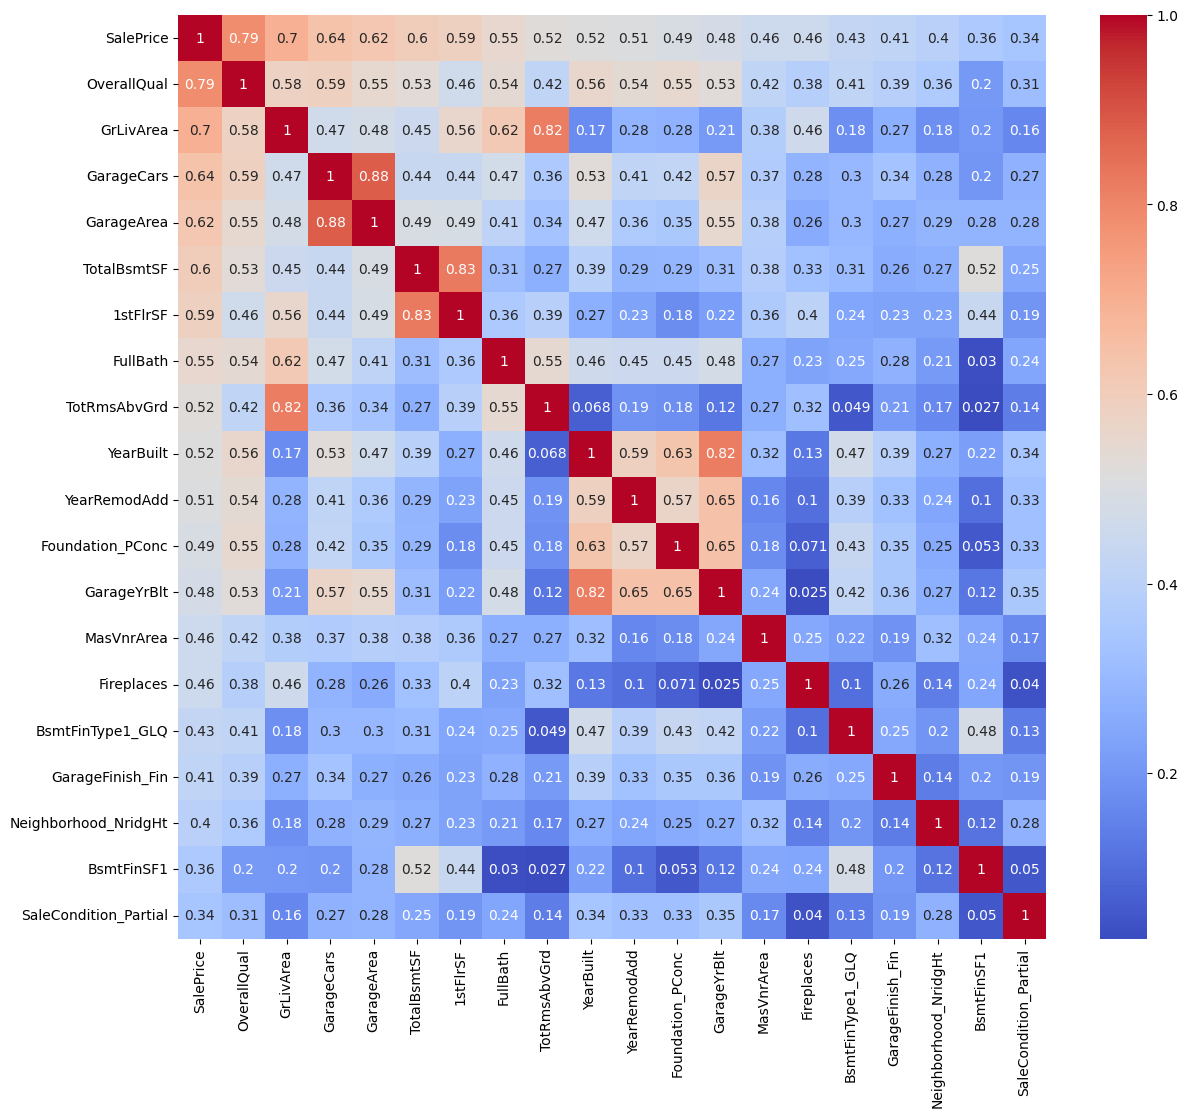

In [18]:
# Matriz de correlación para las variables mayormente asociadas con SalePrice utilizando estandarización
sale_price_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)
# Eligimos las un estimado de las top 20; puede cambiarse este número
top_features = sale_price_correlation.index[:20]

correlation_matrix_qual = df_train_standardized[top_features].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_qual, annot=True, cmap='coolwarm')

plt.show()

### Variables para estimar precio

Determinar el precio de una propiedad depende de varios factores. Si estimamos basado en una pequeña búsqueda en línea; con los siguientes sitios web:
- [CompassMortage](https://www.compmort.com/what-determines-the-value-of-a-home/)
- [GoodMove](https://goodmove.co.uk/blog/the-5-key-factors-that-determine-your-house-market-value/)
- [Experian](https://www.experian.com/blogs/ask-experian/factors-that-affect-home-value/)

Se llega a que los factores más relevantes son:
- Ubicación 
- Condición y edad del hogar
- Tamaño
- Precios de casas circundantes

Idealmente sería mejor consultar con un experto el precio de una casa, mas no contamos con un expero a disposición. Por lo tanto, se tomó como fuente empresas de bienes raíces:
- [FORSALEbyOwner](https://www.forsalebyowner.com/blog/how-to-get-an-accurate-valuation-part-1)
- [Realtor](https://www.realtor.com/advice/sell/how-to-price-a-home-in-sellers-market/)
- [Zillow](https://www.zillow.com/learn/how-to-price-home-to-sell/)

Obtenemos un poco más de información respecto a las variables y consideraciones a la hora de estimar el valor de una propiedad. 
- Fecha de construcción (edad de la casa).
- Dimensiones del hogar $m^2$; número de habitaciones, baños, cubículos, etc.
- Remodelaciones, renovaciones o trabajos hechos a la propiedad.
- Ubicaicón de la propiedad
- Amenidades (i.e seguridad, jardín, etc)
- Precio de servicios 
- Precios recientes de propiedades circundantes
- Tendencias del mercado y condiciones económicas

Lo anterior dicho ya trranscrito en las variables que tenemos para utilizar nos resulte en las siguientes variables:

* OverallQual
* GrLivArea
* tTotalBsmtSF
* GarageCars
* GarageArea
* 1stFlrSF
* FullBath
* TotRmsAbcGrd



### Pruebas de normalidad y correlación

### Análisis de agrupamiento

## Ingeniería de Características

### Selección de variables relevantes

En base a las variables que parecen estar fuertemente relacionadas con el SalePrice de la casa:

* OverallQual
* GrLivArea
* tTotalBsmtSF
* GarageCars
* GarageArea
* 1stFlrSF
* FullBath
* TotRmsAbcGrd

Se realizará un análisis de ellas para poder obtener datos más relevantes.

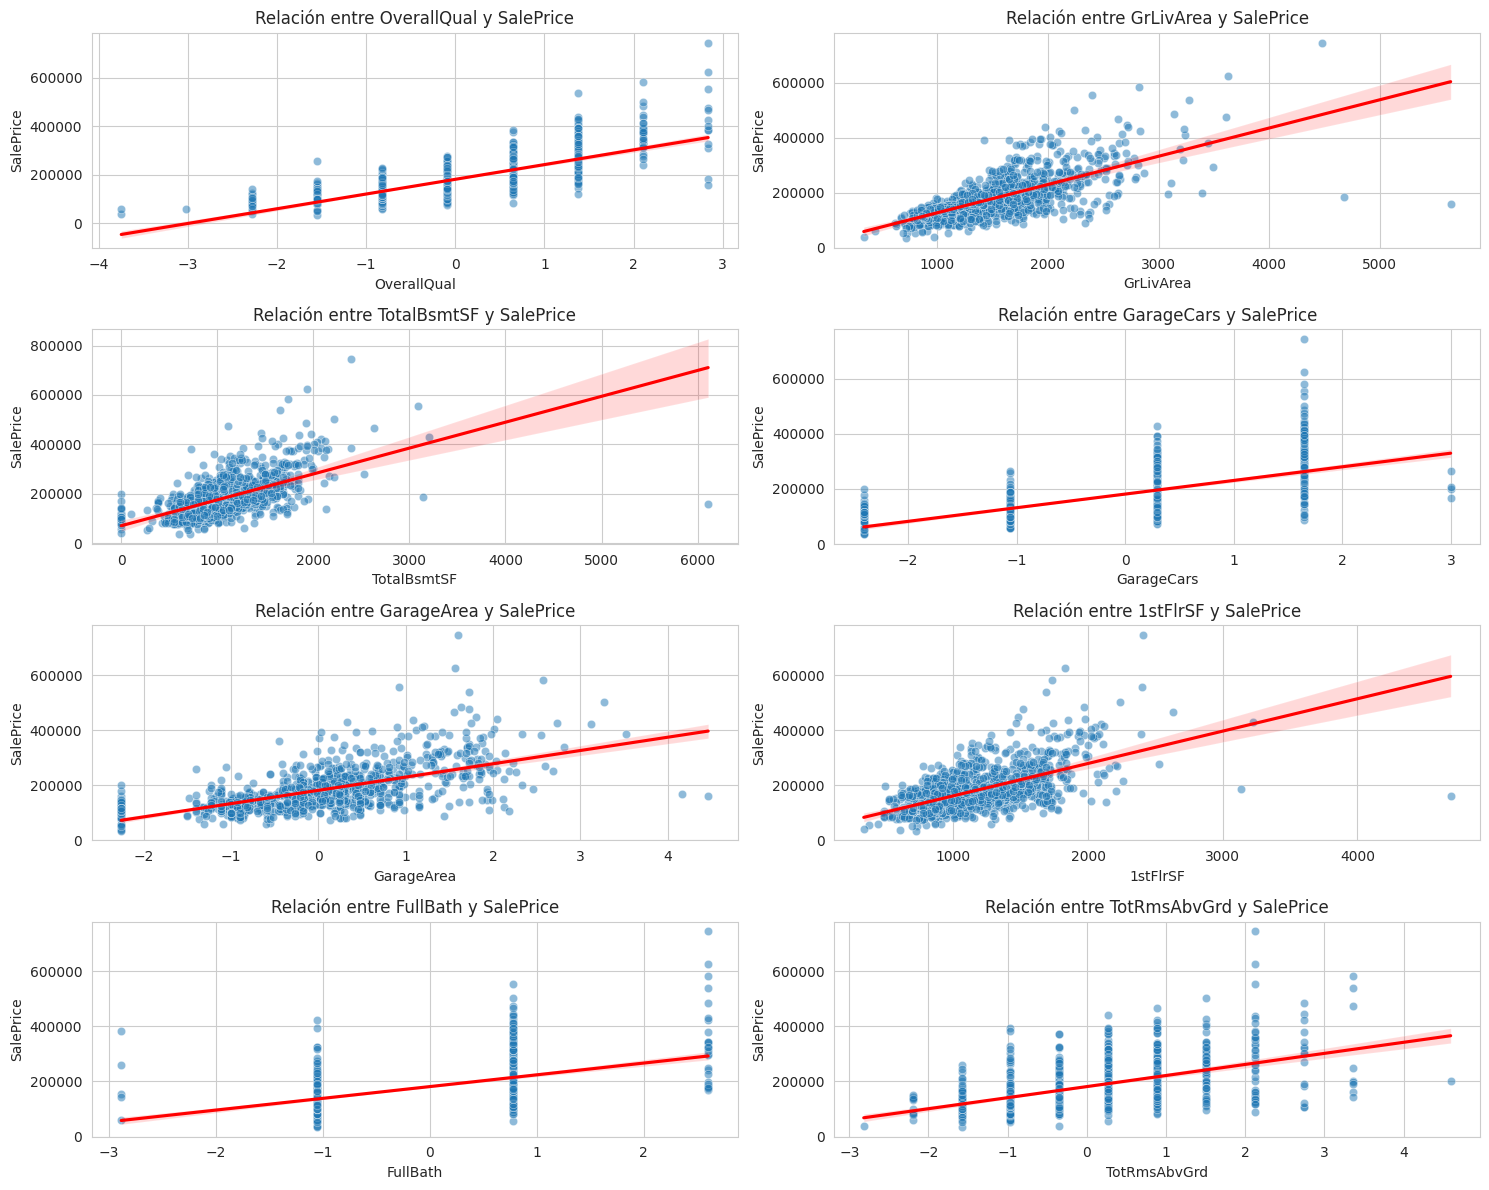

In [19]:
#Variables relevantes
variables = ["OverallQual", "GrLivArea", "TotalBsmtSF", "GarageCars", 
             "GarageArea", "1stFlrSF", "FullBath", "TotRmsAbvGrd"]

sns.set_style("whitegrid")
plt.figure(figsize=(15, 12))

for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.scatterplot(x=df_train_standardized[var], y=df_train_standardized["SalePrice"], alpha=0.5)
    sns.regplot(x=df_train_standardized[var], y=df_train_standardized["SalePrice"], scatter=False, color="red")  # Línea de tendencia
    plt.title(f"Relación entre {var} y SalePrice")

plt.tight_layout()
plt.show()

Entre estas variables, las que se encuentran más fuertemente correlacionadas con SalePrice son OverallQual, GrLivArea, totalBsmtSF y 1stFlrSF. Entre las variables seleccionadas, se pueden observar algunos outliers.

In [25]:
import scipy.stats as skew  # Renombraste stats como skew

print("\n🔹 Correlación con SalePrice:")

for var in variables:
    pearson_corr, pearson_p = skew.pearsonr(df_train_standardized[var], df_train_standardized["SalePrice"])  
    spearman_corr, spearman_p = skew.spearmanr(df_train_standardized[var],df_train_standardized["SalePrice"])  

    print(f"{var}: Pearson r={pearson_corr:.3f} (p={pearson_p:.5f}), Spearman r={spearman_corr:.3f} (p={spearman_p:.5f})")



🔹 Correlación con SalePrice:
OverallQual: Pearson r=0.786 (p=0.00000), Spearman r=0.801 (p=0.00000)
GrLivArea: Pearson r=0.696 (p=0.00000), Spearman r=0.723 (p=0.00000)
TotalBsmtSF: Pearson r=0.598 (p=0.00000), Spearman r=0.595 (p=0.00000)
GarageCars: Pearson r=0.641 (p=0.00000), Spearman r=0.687 (p=0.00000)
GarageArea: Pearson r=0.624 (p=0.00000), Spearman r=0.639 (p=0.00000)
1stFlrSF: Pearson r=0.588 (p=0.00000), Spearman r=0.566 (p=0.00000)
FullBath: Pearson r=0.553 (p=0.00000), Spearman r=0.626 (p=0.00000)
TotRmsAbvGrd: Pearson r=0.520 (p=0.00000), Spearman r=0.521 (p=0.00000)


Por medio del analisis de correlaciones con Spearman podemos medir que tan bien una variable sigue ya sea una tendencia creciente o decreciente. Las variables que muestran una fuerte correlacion positiva (siendo esto r>0.6) son OverallQual, GrLIveArea, GarageCars y GarageArea. Esto nos da a indicar las casas de mejor calidad suelen valer más al igual que las casas con mayor área habitable y el espacio de garage.

### Creación de nuevas características

### Análisis de multicolinealidad